In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

from zipfile import ZipFile
file_name = "/content/gdrive/MyDrive/fer2013.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Mounted at /content/gdrive
Done


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define the path to the FER2013 dataset
dataset_path = '/content/fer2013/'
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Define the mapping from folder names to integer labels
emotion_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'sad': 4,
    'surprise': 5,
    'neutral': 6
}

# Helper function to preprocess images
def preprocess_data(data_dir, mapping):
    images = []
    labels = []
    for emotion_dir in os.listdir(data_dir):
        emotion_path = os.path.join(data_dir, emotion_dir)
        for image_name in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
            images.append(image)
            labels.append(mapping[emotion_dir])
    return np.array(images), np.array(labels)

# Preprocess the data
X_train, y_train = preprocess_data(train_dir, emotion_mapping)
X_test, y_test = preprocess_data(test_dir, emotion_mapping)

# # Create a validation set from the training set
# validation_split = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_split, stratify=y_train, random_state=42)

In [ ]:
import cv2
from sklearn.cluster import KMeans

# Feature descriptor (SIFT)
sift = cv2.SIFT_create()

def extract_sift_features(images, min_keypoints=10):
    features = []
    valid_indices = []
    for i, img in enumerate(images):
        kp, des = sift.detectAndCompute(img, None)
        if des is not None and des.shape[0] >= min_keypoints:
            features.append(des)
            valid_indices.append(i)
    return features, valid_indices

# Extract SIFT features for all images
sift_features_train, valid_indices_train = extract_sift_features(X_train)
# sift_features_val, valid_indices_val = extract_sift_features(X_val)
sift_features_test, valid_indices_test = extract_sift_features(X_test)

# Create the visual vocabulary using k-means clustering
k = 100   #100 visual words
kmeans = KMeans(n_clusters=k)
kmeans.fit(np.vstack(sift_features_train))

# Helper function to create a BoVW histogram
def create_bovw_histogram(features, kmeans):
    hist = np.zeros((len(features), kmeans.n_clusters))
    for i, des in enumerate(features):
        if des is not None:
            words = kmeans.predict(des)
            for word in words:
                hist[i, word] += 1
    return hist

# Create BoVW histograms for all images
bovw_train = create_bovw_histogram(sift_features_train, kmeans)
# bovw_val = create_bovw_histogram(sift_features_val, kmeans)
bovw_test = create_bovw_histogram(sift_features_test, kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import numpy as np

# Save the BoVW features to disk
np.save('bovw_train.npy', bovw_train)
np.save('bovw_val.npy', bovw_val)
np.save('bovw_test.npy', bovw_test)

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/gdrive/MyDrive/ResNet50V2_Model.h5')

model.layers.pop()

model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-1].output)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model

# # Load the pre-trained MobileNetV2 model
# base_model = MobileNetV2(weights='imagenet', include_top=True)
# # Remove the last layer to use the penultimate layer for feature extraction
# model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Helper function to preprocess images for the CNN model
def preprocess_images_cnn(images, target_size=(224, 224)):
    preprocessed_images = []
    for img in images:
        img = cv2.resize(img, target_size)
        img = np.stack((img,)*3, axis=-1)  # Convert grayscale to 3-channel images
        img = img_to_array(img)
        img = preprocess_input(img)
        preprocessed_images.append(img)
    return np.array(preprocessed_images)

# Preprocess the images for the CNN model
X_train_cnn = preprocess_images_cnn(X_train)
# X_val_cnn = preprocess_images_cnn(X_val)
X_test_cnn = preprocess_images_cnn(X_test)

# Extract the CNN features
cnn_train = model.predict(X_train_cnn)
# cnn_val = model.predict(X_val_cnn)
cnn_test = model.predict(X_test_cnn)

225/225 [==============================] - 3s 14ms/step


In [ ]:
cnn_train = cnn_train[valid_indices_train]
# cnn_val = cnn_val[valid_indices_val]
cnn_test = cnn_test[valid_indices_test]

In [ ]:
import numpy as np

# Save the CNN features to disk
np.save('cnn_train.npy', cnn_train)
np.save('cnn_val.npy', cnn_val)
np.save('cnn_test.npy', cnn_test)

In [ ]:
# Load the saved BoVW features from disk
bovw_train = np.load('bovw_train.npy')
bovw_val = np.load('bovw_val.npy')
bovw_test = np.load('bovw_test.npy')

# Load the saved CNN features from disk
cnn_train = np.load('cnn_train.npy')
cnn_val = np.load('cnn_val.npy')
cnn_test = np.load('cnn_test.npy')

In [ ]:
# Concatenate BoVW and CNN features
combined_train = np.hstack((bovw_train, cnn_train))
# combined_val = np.hstack((bovw_val, cnn_val))
combined_test = np.hstack((bovw_test, cnn_test))

# Normalize the combined feature vectors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
combined_train = scaler.fit_transform(combined_train)
# combined_val = scaler.transform(combined_val)
combined_test = scaler.transform(combined_test)

In [ ]:
y_train = y_train[valid_indices_train]
# y_val = y_val[valid_indices_val]
y_test = y_test[valid_indices_test]

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train a Support Vector Machine (SVM) classifier
svm = SVC(kernel='rbf', C=1)
svm.fit(combined_train, y_train)

# # Validate the model
# y_val_pred = svm.predict(cnn_val)
# val_accuracy = accuracy_score(y_val, y_val_pred)
# print(f"Validation accuracy: {val_accuracy:.4f}")

SVC(C=1)

In [ ]:
# Test the model

y_test_pred = svm.predict(combined_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

# Compute other performance metrics
from sklearn.metrics import classification_report
print("Classification report:")
print(classification_report(y_test, y_test_pred))

Test accuracy: 0.6067
Classification report:
              precision    recall  f1-score   support

           0       0.53      0.47      0.50       951
           1       0.82      0.54      0.65       111
           2       0.44      0.45      0.45      1023
           3       0.85      0.79      0.82      1767
           4       0.45      0.50      0.47      1241
           5       0.74      0.73      0.74       826
           6       0.55      0.60      0.58      1228

    accuracy                           0.61      7147
   macro avg       0.63      0.58      0.60      7147
weighted avg       0.61      0.61      0.61      7147



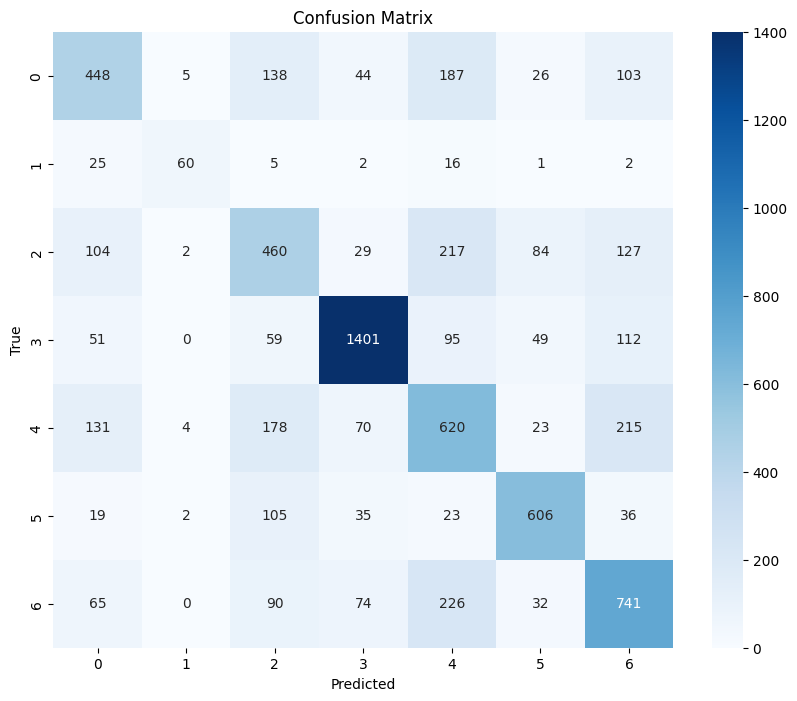

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()